# Trials for KFAC

In [1]:
using Pkg
Pkg.activate(".")
using LaplaceRedux
using LaplaceRedux.Curvature
using LaplaceRedux.Data
using Flux
using Flux.Optimise: update!, Adam
using Plots
using Statistics
using MLUtils
using Zygote
using Random

using NNlib
using Tullio
using LinearAlgebra
using BlockDiagonals

using Colors, Plots

using Serialization
using CSV
using Tables
using JSON
using DataFrames

using Printf
using PrettyPrinting

using BenchmarkTools

  Activating new project at `~/Builds/navimakarov/LaplaceRedux.jl/dev/notebooks/KFAC/sb`
[ Info: Precompiling LaplaceRedux [c52c1a26-f7c5-402b-80be-ba1e638ad478]


## Row-col-order conversion procedures and other utils

In [2]:
function gen_mapping_sq(params)::Array{Tuple{Int64, Int64}}
    mapping_lin = gen_mapping(params)
    length_theta = sum(length, params)
    mapping_sq = Array{Tuple{Int64, Int64}}(undef, length_theta, length_theta)
    for (i, i_) in enumerate(mapping_lin)
        for (j, j_) in enumerate(mapping_lin)
            mapping_sq[i, j] = (i_, j_)
        end
    end
    return mapping_sq
end

import Base: getindex

function getindex(r::Matrix{Float64}, I::Matrix{Tuple{Int64, Int64}})
    l = Matrix{Float64}(undef, size(I))
    for (i, j) in Iterators.product(1:size(I, 1), 1:size(I, 2))
        # Unpack 2d index
        x, y = I[i, j]
        l[i, j] = r[x, y]
    end
    return l
end

function gen_mapping(params)
    theta_length = sum(length, params)
    offset = 0
    mapping = []
    for param in params
        indices = collect(1:length(param))
        indices_updated = vec(reshape(offset .+ indices, size(param))')
        append!(mapping, indices_updated)
        offset += length(param)
    end
    mapping
end

gen_mapping_sqt(params) = gen_mapping_sq(map(transpose, params))
to_col_order(H, nn) = H[gen_mapping_sqt(Flux.params(nn))]
to_row_order(H, nn) = H[gen_mapping_sq(Flux.params(nn))]

# A macro for zero-based indexing
macro zb(expr)
    if expr.head == :ref
        a, i = expr.args
        return Expr(:ref, esc(a), Expr(:call, :+, esc(i), 1))
    else
        error("Expected expr of form a[i], got: ($(expr)) with head $(expr.head)")
    end
end

### Plotting

function norm_abs(H)
    H_abs = broadcast(abs, H)
    H_abs ./ findmax(H_abs)[1]
end

function flip(H)
    H[end:-1:1, :]
end

grayplot(H) = plot(Gray.(norm_abs(H)))

function scanl(f::Function, init::Any, iter)
    res = [init]
    acc = init
    for elem in iter
        acc = f(acc, elem)
        push!(res, acc)
    end
    return res
end

function colplot(H; color=:seismic, nn=nothing)
    lim, = findmax(abs, H)
    title = "mean=$(mean(H)),\n median=$(median(H))"
    if !isnothing(nn)
        heatmap(flip(H), color=color, ratio=:equal, clims=(-lim, lim), title=title)
        accsum = x -> scanl((+), 0, x)
        vlines = accsum(map(length, Flux.params(nn)))
        vline!(.5 .+ vlines, linestyle=:dash, linecolor=:black)
        total = sum(length, Flux.params(nn))
        hlines = total .- vlines
        hline!(.5 .+ hlines, linestyle=:dash, linecolor=:black)
    else
        heatmap(flip(H), color=color, ratio=:equal, clims=(-lim, lim), title=title)
    end
end

from_csv(fname) = Matrix(CSV.read(fname, DataFrame))
to_csv(mtx, fname) = CSV.write(fname, Tables.table(mtx))

function jointplot(H)
    colplot(hcat(H, H))
    grayplot!(H)
end

flat(grads::Zygote.Grads) = reduce(vcat, [vec(grads[t]) for t in grads.params])

function interleave(iters...)
    return (elem for pack in zip(iters...) for elem in pack)
end

interleave (generic function with 1 method)

## Generic setup (~~regression~~ ~~binary~~ multi-class classification task)

In [4]:
# Init data
n = 2000
data_dict = Dict()
# bsize = 10
# ommit bsizes for now

# Classification multi:
xs, y = LaplaceRedux.Data.toy_data_multi(n)
ytrain = Flux.onehotbatch(y, unique(y))
ytrain = Flux.unstack(ytrain'; dims=1)
X = reduce(hcat, xs)
Y = reduce(hcat, ytrain)
data = zip(xs, ytrain)
data_dict[:classification_multi] = Dict(
    :data => data,
    :X => X,
    :Y => Y,
    :y => y,
    :outdim => length(first(ytrain)),
    :loss_fun => :logitcrossentropy,
    :likelihood => :classification,
)

# Take one datapoint of the dataset
x_1 = xs[1]
y_1 = y[1]

1.0

In [5]:
# Init a NN model

val = data_dict[:classification_multi]

# Unpack:
data = val[:data]
X = val[:X]
y = val[:y]
outdim = val[:outdim]
loss_fun = val[:loss_fun]
likelihood = val[:likelihood]

# Neural network:
n_hidden = 32
D = size(X, 1)
nn = Chain(Dense(D, n_hidden, σ), Dense(n_hidden, outdim))
λ = 0.01
sqnorm(x) = sum(abs2, x)
weight_regularization(λ=λ) = 1 / 2 * λ^2 * sum(sqnorm, Flux.params(nn))
loss(x, y) = getfield(Flux.Losses, loss_fun)(nn(x), y) + weight_regularization()

loss (generic function with 1 method)

In [4]:
# Train a NN model

opt = Adam()
epochs = 200
avg_loss(data) = mean(map(d -> loss(d[1], d[2]), data))
show_every = epochs / 10

for epoch in 1:epochs
    for d in data
        gs = gradient(Flux.params(nn)) do
            l = loss(d...)
        end
        update!(opt, Flux.params(nn), gs)
    end
    if epoch % show_every == 0
        println("Epoch " * string(epoch))
        @show avg_loss(data)
    end
end

H_facs = nothing

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 32, σ)   # 96 parameters
│   summary(x) = "2-element Vector{Float64}"
└ @ Flux ~/.julia/packages/Flux/EHgZm/src/layers/stateless.jl:60


Epoch 20
avg_loss(data) = 0.021402219128424972
Epoch 40
avg_loss(data) = 0.020917495333537213
Epoch 60
avg_loss(data) = 0.02089470307404119
Epoch 80
avg_loss(data) = 0.020893781828830817
Epoch 100
avg_loss(data) = 0.0208937937740011
Epoch 120
avg_loss(data) = 0.020893843478417707
Epoch 140
avg_loss(data) = 0.020893839612916812
Epoch 160
avg_loss(data) = 0.020893836287908918
Epoch 180
avg_loss(data) = 0.02089386345031233
Epoch 200
avg_loss(data) = 0.0208938294446474


### Export data and network

In [6]:
CSV.write("Y.csv", Tables.table(Y'))
CSV.write("X.csv", Tables.table(X'))

"X.csv"

In [7]:
function serialize_json_nn(nn::Chain)::String
    JSON.json([Dict(:weight => nn.layers[i].weight, :bias => nn.layers[i].bias)
            for i in range(1, length(nn.layers))])
end

write("nn.json", serialize_json_nn(nn))

2649

In [8]:
serialize("nn.jlb", nn)

In [28]:
# See the net weights
foreach(display, Flux.params(nn))

32×2 Matrix{Float32}:
 -0.0904743   0.814991
 -0.754638    0.0358329
 -0.0904747   0.814991
  0.0464142  -0.847292
  0.817409   -0.0746586
  0.0464142  -0.847292
  0.0464142  -0.847292
  0.817409   -0.0746587
 -0.090474    0.814992
 -0.0904741   0.814992
  0.817408   -0.0746586
 -0.754638    0.0358329
 -0.090474    0.814992
  ⋮          
  0.817408   -0.0746586
 -0.090474    0.814992
 -0.754638    0.0358329
 -0.090474    0.814992
 -0.754638    0.0358329
 -0.754638    0.0358329
  0.817408   -0.0746586
 -0.754638    0.0358329
  0.0464142  -0.847292
 -0.0904749   0.81499
  0.817409   -0.0746586
 -0.0904741   0.814992

32-element Vector{Float32}:
  0.120017104
 -0.22708914
  0.12001695
 -0.1530638
  0.23807015
 -0.1530638
 -0.1530638
  0.23807018
  0.12001727
  0.1200172
  0.2380694
 -0.22708914
  0.12001727
  ⋮
  0.23806958
  0.12001727
 -0.22708914
  0.12001727
 -0.22708914
 -0.22708914
  0.23806952
 -0.22708914
 -0.1530638
  0.12001679
  0.23807
  0.12001719

4×32 Matrix{Float32}:
  0.427143  -0.650278   0.42714   …   0.427139   0.408309   0.427144
 -0.51791    0.356715  -0.51791      -0.51791   -0.564666  -0.51791
 -0.530427  -0.395873  -0.530426     -0.530426   0.691966  -0.530428
  0.63539    0.318608   0.635389      0.635389  -0.610991   0.63539

4-element Vector{Float32}:
 -0.49842957
  0.00074415805
  0.024189202
  0.0064032087

### Import data

In [6]:
Y = permutedims(from_csv("Y.csv"))
X = permutedims(from_csv("X.csv"))

y = ytrain = collect(eachcol(Y))
xs = collect(eachcol(X))
x_1 = xs[1]

# Import a network
nn = deserialize("nn.jlb")

Chain(
  Dense(2 => 32, σ),                    # 96 parameters
  Dense(32 => 4),                       # 132 parameters
)                   # Total: 4 arrays, 228 parameters, 1.141 KiB.

## KFAC Fisher

In [5]:
mutable struct Kron2
    # TODO union types
    # kfacs :: Union{Vector{Tuple{AbstractArray, AbstractArray}},Vector{Matrix},Nothing}
    kfacs :: Vector{Tuple{Matrix, Matrix}}
end

Kron = Kron2

    
# mutable struct KronDecomposed
#     eigenvectors :: Union{AbstractArray,Nothing}
#     eigenvalues :: Union{AbstractArray,Nothing}
#     damping :: Bool
# end


Kron2

In [22]:
lossf = Flux.Losses.logitcrossentropy

function get_krons(xs)
    
    @assert !isempty(xs)
    # `d` is a zero-indexed array with layers sizes
    # `_zb` marks zero-based arrays: these should be accessed via the @zb macro

    d_zb = [[size(xs[1])]; map(a -> size(a), collect(Flux.activations(nn, xs[1])))]
    @show d_zb
    n_layers = length(nn.layers)
    @show n_layers
    n_params = sum(length, Flux.params(nn))
    
    N = size(xs, 1)

    double(sz) = (sz[1], sz[1])
    
    G_exp = [zeros(double(@zb d_zb[i])) for i in 1:n_layers]
    # A separate matrix for bias-based gradients.
    G_exp_b = [zeros(double(@zb d_zb[i])) for i in 1:n_layers]
    @show map(size, G_exp)
    A_exp_zb = [zeros(double(@zb d_zb[i])) for i in 0:(n_layers-1)]
    @show map(size, A_exp_zb)
    
    for n in 1:N
        x_n = xs[n]
        a_zb = [[x_n]; collect(Flux.activations(nn, x_n))]
        p = softmax(nn(x_n))
        
        # Approximate the expected value of the activation outer product A = aa'
        # across all samples x_n,
        # from the input to the pen-ultimate layer activation.
        A_exp_zb += [(@zb a_zb[i]) * transpose(@zb a_zb[i]) for i in 0:(n_layers-1)]
        
        # Approx. the exp. value of the gradient (wrt layer non-activated output) outer product G = gg'
        # via the model's predictive distribution.
        for (j, yhat) in enumerate(eachcol(I(length(p))))
            lossm = m -> lossf(m(x_n), yhat)
            grad, = gradient(lossm, nn)
            
            # See Martens & Grosse 2015 page 5
            # DW[i] <- g[i] * a[i-1]'
            # In our case grads is DW
            g = [grad.layers[i].weight * pinv(transpose(@zb a_zb[i - 1])) for i in 1:n_layers]
            
            G = p[j] .* [g[i] * transpose(g[i]) for i in 1:n_layers]
            G_exp += G
            G_exp_b += G
        end
     
    end
    
    # Downscale the sums for A and G by the number of samples.
    # The division is distributed across the two factors by a sqrt.
    # G_exp /= sqrt(N)
    # A_exp_zb /= sqrt(N)
    # G_exp /= N
    A_exp_zb /= N
    
    # The activation for the bias is simply one.
    # TODO: make Kron.kfacs a union type and include only the G
    A_exp_b_zb = [[1;;] for _ in 1:n_layers]
    # NOTE: [1;;] instead of [1] to produce a 1x1 matrix (vectors are not eigendecomposable)
    # Q: why is the G not scaled in pytorch? bug?
    # G_exp_b /= N
    
    # return Kron(collect(zip(A_exp_zb, G_exp)))
    # return Kron(collect(interleave(zip(A_exp_zb, G_exp), zip(A_exp_b_zb, G_exp_b))))
    return Kron(collect(interleave(zip(G_exp, A_exp_zb), zip(G_exp_b, A_exp_b_zb))))
end

# P_mats = [P[1:64, 1:64], P[97:224, 97:224]]
# P_median = median(reduce(vcat, map(vec, P_mats)))
# NOTE: the two coincide up to 4-5 decimal digits
# -0.064013387

# B_median = median(reduce(vcat, map(vec, mats)))

# F_mats = [F[1:64, 1:64], F[97:224, 97:224]]
# F_median = median(reduce(vcat, map(vec, F_mats)))

get_krons (generic function with 1 method)

In [30]:
K = get_krons(xs)
mats = [kron(A, G) for (G, A) in K.kfacs]
BK = Q = BlockDiagonal(mats)
colplot(Q, nn=nn)
@show map(t -> map(size, t), K.kfacs)
# println("First factor:")
KD = DK = D = decompose(K);

d_zb = [(2,), (32,), (4,)]
n_layers = 2
map(size, G_exp) = [(32, 32), (4, 4)]
map(size, A_exp_zb) = [(2, 2), (32, 32)]
map((t->begin
            #= In[30]:5 =#
            map(size, t)
        end), K.kfacs) = [((32, 32), (2, 2)), ((32, 32), (1, 1)), ((4, 4), (32, 32)), ((4, 4), (1, 1))]


In [29]:
# # print out all factors
# #foreach(t -> begin i, fac = t; println(); @show i; foreach(display, fac) end, enumerate(K.kfacs))
# for (i, block) in enumerate(K.kfacs)
#     println()
#     @show i
#     foreach(display, block)
#     println()
# end
# # print out how they are decomposed
# for (i, block) in enumerate(KD.kfacs)
#     println()
#     @show i
#     foreach(display, block)
#     println()
# end

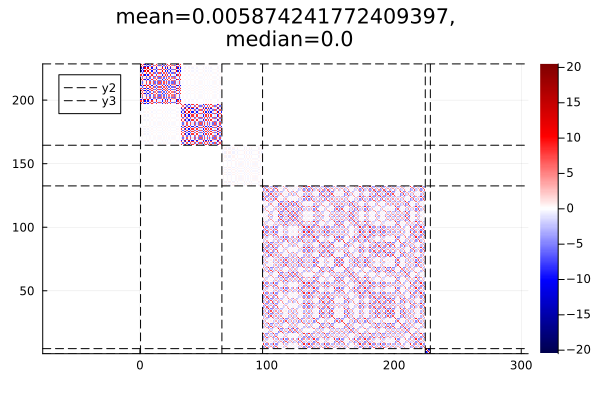

In [11]:
P = from_csv("B.csv")
P = to_col_order(P, nn)
@assert isapprox(P, Q, atol=.002) # cool
# the median is -0.064013387
colplot(P, nn=nn)
# Note, this is not Fisher but GGN (backend being ASDL)

In [12]:
colplot(P - Q, nn=nn)
findmax(abs, P - Q) # The worst difference between the two is only on the fifth significant digit
# H_torch_col = H_torch[gen_mapping_sqt(Flux.params(nn))]
# @assert isapprox(H_torch_col, EF, atol=.0005)

(5.184892812160058e-5, CartesianIndex(227, 227))

### Cont: Kron decomposed

In [56]:
mutable struct KronD5
    # TODO union types
    # kfacs :: Union{Vector{Tuple{AbstractArray, AbstractArray}},Vector{Matrix},Nothing}
    # kfacs :: Vector{Tuple{AbstractArray, AbstractArray}}
    kfacs::Vector{Tuple{Eigen, Eigen}}
    delta::Number
end

KronDecomposed = KronD = KronD5

unzip(a) = map(x->getfield.(a, x), fieldnames(eltype(a)))

function clamp(eig::Eigen)
    Eigen(max.(0, eig.values), eig.vectors)
end

"""
Eigendecompose Kronecker factors and turn into `KronDecomposed`.
"""   
function decompose(K::Kron)
    # TODO filter out negative eigenvals
    return KronDecomposed(map(b -> map(clamp ∘ eigen, b), K.kfacs), 0)
end

# function logdet(k::Kron)
#     return sum(blocklogdet, k.kfacs)
# end

#function logdetblock(block, delta::Number)
#    if length(block) == 1
#        return sum(log(block .+ delta))
#    elseif length(block) == 2
#        evals1, evals2 = block.values
#        return sum(log(evals1 * transpose(evals2)))
#    else
#        error('Too many Kronecker factors. Something went wrong.')
#    end
#end

function logdetblock(block::Tuple{Eigen, Eigen}, delta::Number)
    L1, L2 = block.values
    return sum(log(L1 * transpose(L2) + delta))
end

function logdet(K::KronDecomposed)
    return sum(b -> logdetblock(b, K.delta), K.kfacs)
end

function detblock(block::Tuple{Eigen, Eigen}, delta::Number)
    L1, L2 = block.values
    return sum(log(L1 * transpose(L2) + delta))
end

function det(K::KronDecomposed)
    return sum(b -> detblock(b, K.delta), K.kfacs)
end


#        logdet = 0
#        for ls, delta in zip(self.eigenvalues, self.deltas):
#            if len(ls) == 1:  # not KFAC just full
#                logdet += torch.log(ls[0] + delta).sum()
#            elif len(ls) == 2:
#                l1, l2 = ls
#                if self.damping:
#                    l1d, l2d = l1 + torch.sqrt(delta), l2 + torch.sqrt(delta)
#                    logdet += torch.log(torch.outer(l1d, l2d)).sum()
#                else:
#                    logdet += torch.log(torch.outer(l1, l2) + delta).sum()
#            else:
#                raise ValueError('Too many Kronecker factors. Something went wrong.')
#        return logdet


#     def _bmm(self, W: torch.Tensor, exponent: float = -1) -> torch.Tensor:

#         # self @ W[batch, k, params]
#         assert len(W.size()) == 3
#         B, K, P = W.size()
#         W = W.reshape(B * K, P)
#         cur_p = 0
#         SW = list()
#         for ls, Qs, delta in zip(self.eigenvalues, self.eigenvectors, self.deltas):

#             Q1, Q2 = Qs
#             l1, l2 = ls
#             p = len(l1) * len(l2)

#             ldelta_exp = torch.pow(torch.outer(l1, l2) + delta, exponent).unsqueeze(0)
#             p_in, p_out = len(l1), len(l2)
#             W_p = W[:, cur_p:cur_p+p].reshape(B * K, p_in, p_out)
#             W_p = (Q1.T @ W_p @ Q2) * ldelta_exp
#             W_p = Q1 @ W_p @ Q2.T
#             SW.append(W_p.reshape(B * K, p_in * p_out))
#             cur_p += p

#         SW = torch.cat(SW, dim=1).reshape(B, K, P)
#         return SW

append_dim(x::AbstractArray) = reshape(x, (size(x)..., 1))
prepend_dim(x::AbstractArray) = reshape(x, (1, size(x)...))
# unsqueeze = append_dim


"""
Matrix-multuply for the KronDecomposed Hessian approximation K and a 2-d matrix W,
applying an exponent to K and transposing W before multiplication.
Return `(K^x)W^T`, where `x` is the exponent.
"""
function mm(K::KronDecomposed, W::Matrix; exponent::Number=-1)
    cur_idx = 1
    @assert length(size(W)) == 2
    k, p = size(W)
    M = []
    for block in K.kfacs
        Q1, Q2 = block[1].vectors, block[2].vectors
        L1, L2 = block[1].values, block[2].values
        # NOTE: should this not be the other way?
        p_in = length(L1)
        p_out = length(L2)
        sz = p_in * p_out

        # NOTE: order of factors is reversed in laplace-torch
        ldelta_exp = (L1 * transpose(L2) .+ K.delta) .^ exponent
       
        W_p = reshape(W[:, cur_idx : cur_idx + sz - 1], k, p_in, p_out)
        W_p = permutedims(stack([Q1 * ((transpose(Q1) * W_p[i, :, :] * Q2) .* ldelta_exp) * transpose(Q2) for i in range(1, size(W_p, 1))]), (3, 1, 2))
        W_p = reshape(W_p, k, sz)
        push!(M, W_p)
        
        cur_idx += sz
    end
    M = reduce(hcat, M)
    return M
end

    # def functional_variance(self, Js):
        # return self.posterior_precision.inv_square_form(Js)

function functional_variance(K::KronDecomposed, Js::Matrix)
    inv_square_form(posterior_precision(K), Js)
end

#     @property
#     def posterior_precision(self):
#         """Kronecker factored Posterior precision \\(P\\).

#         Returns
#         -------
#         precision : `laplace.utils.matrix.KronDecomposed`
#         """
#         self._check_H_init()
#         return self.H * self._H_factor + self.prior_precision

function posterior_precision(K::KronDecomposed, factor, prior_precision)
    return K * factor + prior_precision
end

# verified w pytorch!
function inv_square_form(K::KronDecomposed, W::Matrix)
    SW = mm(K, W; exponent=-1)
    return W * SW'
end

    # def inv_square_form(self, W: torch.Tensor) -> torch.Tensor:
    #     # W either Batch x K x params or Batch x params
    #     SW = self._bmm(W, exponent=-1)
    #     # print()
    #     # print("SW")
    #     # print(SW)
    #     return torch.bmm(W, SW.transpose(1, 2))

# M = mm(D, W)
# @assert M.shape == W.shape

LoadError: error in method definition: function LinearAlgebra.det must be explicitly imported to be extended

In [32]:
x_1 = first(xs)
Js = reduce(hcat, Zygote.jacobian(() -> nn(x_1), Flux.params(nn)))
@show summary(Js)
display(Js)
println()
# @show Js[1, 4]

DK.delta = 1
M = mm(DK, Js)

summary(Js) = "4×228 Matrix{Float32}"


4×228 Matrix{Float32}:
  0.0335768  -0.165121    0.0335768  …  0.0       1.0  0.0  0.0  0.0
 -0.0407119   0.0905786  -0.040712      0.0       0.0  1.0  0.0  0.0
 -0.0416958  -0.100522   -0.0416959     0.0       0.0  0.0  1.0  0.0
  0.0499467   0.0809023   0.0499469     0.971381  0.0  0.0  0.0  1.0

4×228 Matrix{Float64}:
  0.00399118   -0.0193989    0.00399125   …  0.22512   0.250054  0.243797
 -0.00324101   -0.00649209  -0.00324116      0.302801  0.232784  0.239295
 -0.000512247   0.00958207  -0.000512364     0.232784  0.288069  0.229093
  0.00364217   -0.0112674    0.0036423       0.239295  0.229093  0.287814

In [33]:
Js

4×228 Matrix{Float32}:
  0.0335768  -0.165121    0.0335768  …  0.0       1.0  0.0  0.0  0.0
 -0.0407119   0.0905786  -0.040712      0.0       0.0  1.0  0.0  0.0
 -0.0416958  -0.100522   -0.0416959     0.0       0.0  0.0  1.0  0.0
  0.0499467   0.0809023   0.0499469     0.971381  0.0  0.0  0.0  1.0

In [50]:
inv_square_form(DK, Js)

4×4 Matrix{Float64}:
 4.96854  4.67871  4.80529  4.77908
 4.67871  5.07687  4.71708  4.75604
 4.80529  4.71708  5.01022  4.69454
 4.77908  4.75604  4.69454  5.00125

In [45]:
# !=(0).(D.kfacs[1][2].values .>= 0) |> all
# D.kfacs[1][2].values = max.(0, D.kfacs[1][2].values)
M_exp = pinv(BK + diagm(ones(228))) * Js'
@assert isapprox(M_exp', M, atol=1e-6)
M_exp' # this would make for a good test case

4×228 adjoint(::Matrix{Float64}) with eltype Float64:
  0.00201543  -0.00594819   0.00201548  …  0.224783  0.249565  0.243745
 -0.00453031  -0.00157203  -0.00453056     0.303061  0.231693  0.240462
 -0.00394923   0.00128341  -0.00394941     0.231693  0.290238  0.228504
  0.00860574  -0.00338012   0.00860592     0.240462  0.228504  0.287289

In [361]:
Q + DQ

228×228 BlockDiagonal{Float64, Matrix{Float64}}:
 16.8189    -0.217316   8.40943   …   0.0           0.0        0.0
 -0.217316  11.0121    -0.217311      0.0           0.0        0.0
  8.40943   -0.217311  16.8188        0.0           0.0        0.0
 -9.49207    1.12733   -9.49205       0.0           0.0        0.0
 -1.05383   -6.01081   -1.05384       0.0           0.0        0.0
 -9.49207    1.12733   -9.49205   …   0.0           0.0        0.0
 -9.49207    1.12733   -9.49205       0.0           0.0        0.0
 -1.05383   -6.01081   -1.05384       0.0           0.0        0.0
  8.40945   -0.21732    8.40944       0.0           0.0        0.0
  8.40945   -0.217319   8.40944       0.0           0.0        0.0
 -1.05383   -6.0108    -1.05383   …   0.0           0.0        0.0
 -0.217316   5.50603   -0.217311      0.0           0.0        0.0
  8.40945   -0.21732    8.40944       0.0           0.0        0.0
  ⋮                               ⋱   ⋮                       
  0.0        0.0 

In [360]:
DQ = Diagonal(diag(Q))

228×228 Diagonal{Float64, Vector{Float64}}:
 8.40944   ⋅        ⋅         ⋅      …    ⋅        ⋅        ⋅       ⋅ 
  ⋅       5.50603   ⋅         ⋅           ⋅        ⋅        ⋅       ⋅ 
  ⋅        ⋅       8.40942    ⋅           ⋅        ⋅        ⋅       ⋅ 
  ⋅        ⋅        ⋅       11.3275       ⋅        ⋅        ⋅       ⋅ 
  ⋅        ⋅        ⋅         ⋅           ⋅        ⋅        ⋅       ⋅ 
  ⋅        ⋅        ⋅         ⋅      …    ⋅        ⋅        ⋅       ⋅ 
  ⋅        ⋅        ⋅         ⋅           ⋅        ⋅        ⋅       ⋅ 
  ⋅        ⋅        ⋅         ⋅           ⋅        ⋅        ⋅       ⋅ 
  ⋅        ⋅        ⋅         ⋅           ⋅        ⋅        ⋅       ⋅ 
  ⋅        ⋅        ⋅         ⋅           ⋅        ⋅        ⋅       ⋅ 
  ⋅        ⋅        ⋅         ⋅      …    ⋅        ⋅        ⋅       ⋅ 
  ⋅        ⋅        ⋅         ⋅           ⋅        ⋅        ⋅       ⋅ 
  ⋅        ⋅        ⋅         ⋅           ⋅        ⋅        ⋅       ⋅ 
 ⋮                               

In [211]:
        # [1.1595e-14, 1.2593e-14],
        # [1.8808e-08, 2.0428e-08],
        # [3.6671e-08, 3.9830e-08],
        # [6.0650e-08, 6.5874e-08],
        # [1.1564e-07, 1.2560e-07],
        # [2.3381e-07, 2.5395e-07],
        # [2.9594e-07, 3.2143e-07],
        # [4.3194e-07, 4.6914e-07],
        # [6.3046e-07, 6.8476e-07],
        # [1.1539e-06, 1.2533e-06],
        # [2.0684e-06, 2.2466e-06],
        # [2.7137e-06, 2.9475e-06],
        # [5.1336e-06, 5.5758e-06],
        # [6.2142e-06, 6.7495e-06],
        # [7.7787e-06, 8.4486e-06],
        # [8.6853e-01, 9.4334e-01],
        # [1.9742e+00, 2.1443e+00],
        # [1.0124e+02, 1.0996e+02],
        # [1.3332e+02, 1.4480e+02]])
Q2 = rand(32, 32)
W_p = rand(4, 32, 2)
Q1 = rand(2, 2)

2×2 Matrix{Float64}:
 0.941018  0.196054
 0.785152  0.0840422

In [145]:
to_csv(W, "W.csv")
to_csv(M_exp, "M_exp.csv")

"M_exp.csv"

In [27]:
Js

4×228 Matrix{Float32}:
  0.0606085  -0.0548762   0.0606085  …  0.0       1.0  0.0  0.0  0.0
 -0.0734878   0.0301027  -0.0734881     0.0       0.0  1.0  0.0  0.0
 -0.0752638  -0.0334072  -0.0752641     0.0       0.0  0.0  1.0  0.0
  0.0901573   0.026887    0.0901576     0.972979  0.0  0.0  0.0  1.0

### KFAC LA

In [7]:
la = Laplace(nn; likelihood=:classification, backend=:EmpiricalFisher, hessian_structure=:kron)
fit!(la, zip(xs, ytrain))

2-element view(::Matrix{Float64}, :, 1) with eltype Float64:
 5.397032016677978
 4.8491576134069625

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 32, σ)   # 96 parameters
│   summary(x) = "2-element view(::Matrix{Float64}, :, 1) with eltype Float64"
└ @ Flux ~/.julia/packages/Flux/EHgZm/src/layers/stateless.jl:60


2000

In [36]:
la_full = Laplace(nn; likelihood=:classification, backend=:EmpiricalFisher)
fit!(la_full, zip(xs, ytrain))

2000

In [6]:
x_1 = first(xs)

2-element Vector{Float64}:
 2.827638059205656
 4.491412536809463

In [8]:
predict(la, x_1)

summary(fvar) = "4-element Vector{Float64}"


4-element Vector{Float64}:
 4.968537892138553
 5.076873587859925
 5.010220178710081
 5.001252760374719


summary(κ) = "4-element Vector{Float64}"


4-element Vector{Float64}:
 0.582110018708803
 0.5779590269208524
 0.5805023572425924
 0.5808471006910265

4-element Vector{Float64}:
 0.9498778853485769
 4.7405659940087276e-5
 0.026803296161464308
 0.0232714128300189

In [9]:
optimize_prior!(la)

LoadError: MethodError: no method matching getindex(::Tuple{Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}, Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}}, ::Symbol)

[0mClosest candidates are:
[0m  getindex(::Tuple, [91m::Int64[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mtuple.jl:29[24m[39m
[0m  getindex(::Tuple, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mtuple.jl:30[24m[39m
[0m  getindex(::Tuple, [91m::Colon[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mtuple.jl:33[24m[39m
[0m  ...


In [48]:
x_1

2-element Vector{Float64}:
 2.827638059205656
 4.491412536809463

In [40]:
predict(la_full, x_1)

summary(fvar) = "4-element Vector{Float64}"
fvar = [6.644739734160761, 17.90770032963748, 9.195697534669497, 8.390754506451128]


4-element Vector{Float64}:
 0.9007709251438166
 0.001201610711166899
 0.03517629288162422
 0.06285117126339225

In [17]:
Flux.activations(nn, x_1)

(Float32[0.9847084, 0.12578447, 0.9847084, 0.011224824, 0.8703648, 0.011224824, 0.011224824, 0.8703648, 0.98470855, 0.98470855  …  0.12578447, 0.98470855, 0.12578447, 0.12578447, 0.8703645, 0.12578447, 0.01122483, 0.9847083, 0.8703648, 0.98470855], Float32[6.2112374, -9.12888, -0.1433892, 1.77299])

# Verification

## Exact Hessian of a Neural Network Loss

In [64]:
# https://fluxml.ai/Flux.jl/stable/destructure/
model = nn
theta, rebuild = Flux.destructure(model)

Y = reduce(hcat, ytrain)

function lossv(theta::Vector)
    m = rebuild(theta)
    Flux.Losses.logitcrossentropy(m(X), Y)
end;

H = Zygote.hessian(lossv, theta)

228×228 Matrix{Float32}:
  0.0173244    -0.000113876   0.00401995   …  -0.0035228    -0.00154964
 -0.000113876   0.00355347   -0.000113875      0.000700263   0.00111972
  0.00401995   -0.000113875   0.0173244       -0.00352279   -0.00154964
 -0.00429679    0.000195484  -0.00429678       0.00431335    0.0013201
 -0.000168276  -0.000456514  -0.000168276     -0.000506024  -0.00115264
 -0.00429679    0.000195484  -0.00429678   …   0.00431335    0.0013201
 -0.00429679    0.000195484  -0.00429678       0.00431335    0.0013201
 -0.000168276  -0.000456514  -0.000168276     -0.000506024  -0.00115264
  0.00401995   -0.000113876   0.00401995      -0.0035228    -0.00154964
  0.00401995   -0.000113876   0.00401995      -0.0035228    -0.00154964
 -0.000168276  -0.000456513  -0.000168276  …  -0.000506024  -0.00115263
 -0.000113876   0.000388527  -0.000113875      0.000700263   0.00111972
  0.00401995   -0.000113876   0.00401995      -0.0035228    -0.00154964
  ⋮                                       

## Fisher Information

In [61]:
# Compute the Fisher for x_1, theta
# Note: y_1, the training label is not used here.

n_params = sum(length, Flux.params(nn))
F = zeros(n_params, n_params)

lossf = Flux.Losses.logitcrossentropy

for i in 1:length(xs)
    p = softmax(nn(xs[i]))

    for (j, yhat) in enumerate(eachcol(I(length(p))))
        lossm = m -> lossf(m(xs[i]), yhat)
        g, = Flux.destructure(gradient(lossm, nn))
        F += p[j] .* g * g'
    end

end

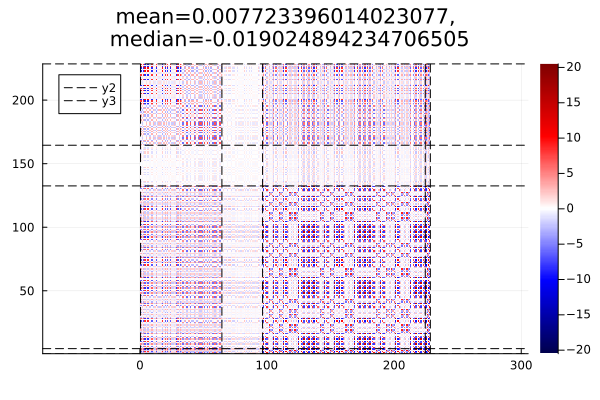

In [59]:
colplot(F, nn=nn)

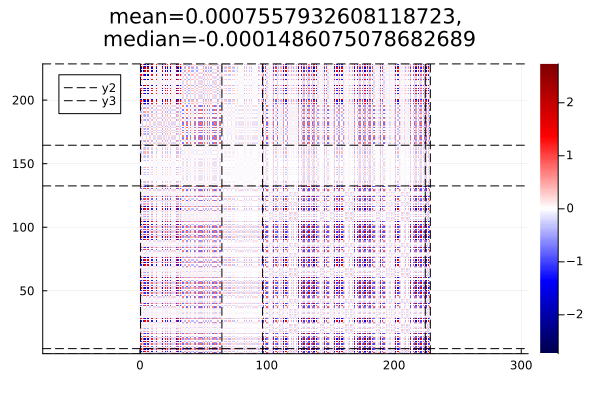

In [58]:
colplot(EF, nn=nn)

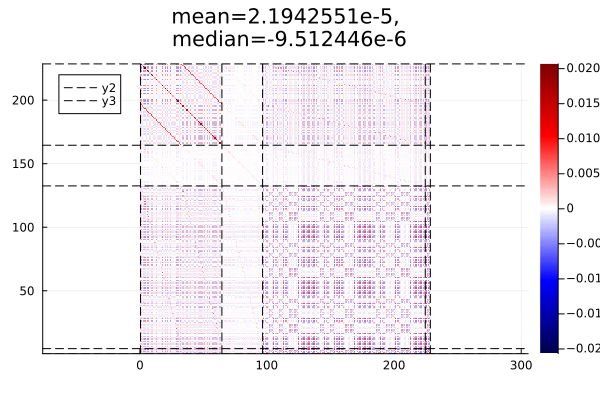

In [67]:
colplot(H, nn=nn)

In [57]:
n_params = sum(length, Flux.params(nn))
EF = zeros(n_params, n_params)

for i in 1:length(xs)
    g, = Flux.destructure(gradient(m -> Flux.Losses.logitcrossentropy(m(xs[i]), ytrain[i]), nn))
    EF += g * g'
end

In [ ]:
mean(F) / mean(H)

351.9825932563952

In [98]:
median(F) / median(H) # wow
# NOTE: F is the true Fisher information matrix,
#   though *not* scaled down by the number of samples (here 2000), hence the difference

2000.0002321692264

In [145]:
median(EF) / median(H)

15.622428517706451

In [50]:
mean(F) / mean(H)

1986.424267158689

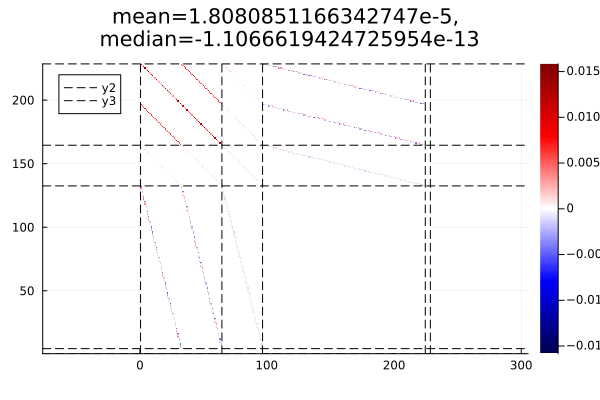

In [68]:
colplot(H - F / 2000, nn=nn)
# NOTE: the approximation is near perfect, except for the diags

## Kron

### Addition

In [175]:
import Base: +, ==, *

function (+)(l::Kron, r::Kron)
    @assert length(l.kfacs) == length(r.kfacs)
    kfacs = [Tuple(Hi + Hj for (Hi, Hj) in zip(Fi, Fj))
                for (Fi, Fj) in zip(l.kfacs, r.kfacs)]
    return Kron(kfacs)
end

function (==)(l::Kron, r::Kron)
    return l.kfacs == r.kfacs
end

# H = [[Fi + Fj for (Fi, Fj) in zip(Fi_row, Fj_row)] for (Fi_row, Fj_row) in zip(H.kfacs, H_batch.kfacs)]
#        kfacs = [[Hi.add(Hj) for Hi, Hj in zip(Fi, Fj)]
#                 for Fi, Fj in zip(self.kfacs, other.kfacs)]

== (generic function with 315 methods)

### Tests

In [9]:
using Test

In [10]:
left = Kron([([1 2], [3 4])])
right = Kron([([5 6], [7 8])])
total = left + right
@test total.kfacs == [([6 8], [10 12])]

Test Passed

In [16]:
left = Kron([([1 2], [3 4]), ([11 12], [13 14])])
right = Kron([([5 6], [7 8]), ([15 16], [17 18])])
total = left + right
@test total.kfacs == [([6 8], [10 12]), ([26 28], [30 32])]

Test Passed

In [13]:
left = Kron([])
total = left + left
@test total == left

Test Passed

In [15]:
left = Kron([([1 2], [3 4]), ([], [])])
right = Kron([([5 6], [7 8])])
@test_throws AssertionError left + right

Test Passed
      Thrown: AssertionError

In [8]:
collect(zip([1, 2, 3], [4, 5, 6, 7]))

3-element Vector{Tuple{Int64, Int64}}:
 (1, 4)
 (2, 5)
 (3, 6)

### Scaling

In [176]:
function (*)(l::Real, r::Kron)
        kfacs = [Tuple(^(l, 1/length(F)) * Hi for Hi in F) for F in r.kfacs]
        return Kron(kfacs)
end

(*)(l::Kron, r::Real) = (*)(r, l)

* (generic function with 627 methods)

### Tests

In [38]:
left = 4
right = Kron([([5 6], [7 8])])
@test left * right == right * left
@test (left * right).kfacs == [([10 12], [14 16])]

Test Passed

## Andrei's code

In [11]:
function init(model)
    kfacs = []

    for p in Flux.params(model)
        if ndims(p) == 1  # bias
            P = size(p, 1)
            push!(kfacs, [zeros(P, P)])
        elseif 4 >= ndims(p) >= 2  # fully connected or conv
            if ndims(p) == 2  # fully connected
                P_in, P_out = size(p)
            elseif ndims(p) > 2
                P_in, P_out = size(p, 1), prod(size(p)[2:end])
            end
            
            push!(kfacs, [
                zeros(P_in, P_in),
                zeros(P_out, P_out)
            ])
        else
            error("Invalid parameter shape in network.")
        end
    end
    # @show kfacs
    # @show get_array_sizes(kfacs)
    # @show print_arrays(kfacs)
    return Kron(kfacs)
end

init (generic function with 1 method)

In [8]:
function fitBeta(la::Laplace, data; batched::Bool=false, batchsize::Int, override::Bool=true)
    if override
        H = init(la.model)          
        loss = 0.0
        n_data = 0
    end

    # Training:
    for d in data
        x, y = d
        loss_batch, H_batch =_curv_closure(la.curvature, x, y, length(data))
        loss += loss_batch
        @show(H_batch)
        @show(H)
        H = [[Fi + Fj for (Fi, Fj) in zip(Fi_row, Fj_row)] for (Fi_row, Fj_row) in zip(H.kfacs, H_batch.kfacs)]
        n_data += batchsize
    end

    # Store output:
    la.loss = loss                                                           # Loss
    la.H = H                                                                 # Hessian
    la.P = posterior_precision(la)                                           # posterior precision
    la.Σ = posterior_covariance(la)                                          # posterior covariance
    return la.n_data = n_data                                                # number of observations
end

fitBeta (generic function with 1 method)

In [45]:
# fitting kron
function fitAux(la, train_loader, override=true, damping=false)
    if override
        H_facs = nothing
    end

    if !isnothing(H_facs)
        n_data_old = la.n_data
        n_data_new = length(train_loader)
        la.H = init(la.model) # re-init H non-decomposed
        # discount previous Kronecker factors to sum up properly together with new ones
        H_facs = _rescale_factors(H_facs, n_data_old / (n_data_old + n_data_new))
    end

    fitBeta(la, train_loader, batched=false, batchsize=1, override=override)

    if isnothing(H_facs)
        H_facs =la.H
    else
        # discount new factors that were computed assuming N = n_data_new
        la.H = _rescale_factors(la.H, n_data_new / (n_data_new + n_data_old))
        H_facs += la.H
    end
    # Decompose to self.H for all required quantities but keep H_facs for further inference
    la.H = decompose(la.H_facs, damping=damping)
end

fitAux (generic function with 3 methods)

In [46]:
function _curv_closure(curvature, x, y, N)
    return kron(curvature, x, y, N) #la.backend.kron(X, y, N=N)
end

_curv_closure (generic function with 1 method)

In [47]:
function posterior_precision(la::Laplace, H=la.H, P₀=la.P₀)
    @assert !isnothing(H) "Hessian not available. Either no value supplied or Laplace Approximation has not yet been estimated."
    return H .+ P₀
end

posterior_precision (generic function with 3 methods)

In [48]:
function posterior_covariance(la::Laplace, P=posterior_precision(la))
    @assert !isnothing(P) "Posterior precision not available. Either no value supplied or Laplace Approximation has not yet been estimated."
    return inv(P)
end

posterior_covariance (generic function with 2 methods)

In [49]:
function kron(curvature, x, y, N)
    #context = ifelse(self.stochastic, KFAC, KFLR)
    loss = curvature.factor * curvature.loss_fun(x, y)
    𝐠 = gradient(() -> curvature.loss_fun(x, y), Flux.params(curvature.model))
    𝐠 = reduce(vcat, [vec(𝐠[i]') for i in curvature.params])  
    # backpack(context()) do
    #     backward(loss)
    # end
    kron = Kron(𝐠)
    @show(kron)
    kron = _rescale_kron_factors(kron, length(y), N)
    return curvature.factor * loss, kron#curvature.factor * detach(loss), curvature.factor * kron
end

kron (generic function with 1 method)

In [50]:
function decompose(kron,damping=false)
    """
    Eigendecompose Kronecker factors and turn into `KronDecomposed`.
    
    Parameters
    ----------
    damping : bool
        use damping

    Returns
    -------
    kron_decomposed : KronDecomposed
    """
    eigvecs = []
    eigvals = []
    for F in kron.kfacs
        Qs = []
        ls = []
        for Hi in F
            l, Q = symeig(Hi)
            push!(Qs, Q)
            push!(ls, l)
        push!(eigvecs, Qs)
        push!(eigvals, ls)
        end
    end
    return KronDecomposed(eigvecs, eigvals, damping=damping)
end

decompose (generic function with 2 methods)

In [51]:
function _rescale_factors(kron, factor)
    for F in kron.kfacs
        if length(F) == 2
            F[1] *= factor
        end
    end
    return kron
end

_rescale_factors (generic function with 1 method)

In [52]:
function _rescale_kron_factors(kron, M, N)
    # Renormalize Kronecker factor to sum up correctly over N data points with batches of M
    # for M=N (full-batch) just M/N=1
    for F in kron.kfacs
        if length(F) == 2
            F[1] *= M/N
        end
    end
    return kron
end

_rescale_kron_factors (generic function with 1 method)

In [160]:
function _get_kron_factors(la)
    return Kron([p.kfac for p in la.model.parameters])
end

┌ Error: Failed to revise /home/vd/Builds/navimakarov/LaplaceRedux.jl/src/curvature/functions.jl
│   exception =
│    LoadError: InterruptException:
│    Stacktrace:
│     [1] var"@tullio"(__source__::LineNumberNode, __module__::Module, exs::Vararg{Any})
│       @ Tullio ~/.julia/packages/Tullio/NGyNM/src/macro.jl:35
│     [2] lower
│       @ ./meta.jl:163 [inlined]
│     [3] methods_by_execution!(recurse::Any, methodinfo::Revise.CodeTrackingMethodInfo, docexprs::Dict{Module, Vector{Expr}}, mod::Module, ex::Expr; mode::Symbol, disablebp::Bool, always_rethrow::Bool, kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
│       @ Revise ~/.julia/packages/Revise/Kw99o/src/lowered.jl:176
│    in expression starting at /home/vd/Builds/navimakarov/LaplaceRedux.jl/src/curvature/functions.jl:144
└ @ Revise ~/.julia/packages/Revise/Kw99o/src/packagedef.jl:721
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /home/vd/Builds/navimakarov

LoadError: syntax: invalid iteration specification

In [ ]:
# dataloader = DataLoader((X, Y), batchsize=10)

200-element DataLoader(::Tuple{Matrix{Float64}, Matrix{Float64}}, batchsize=10)
  with first element:
  (1×10 Matrix{Float64}, 1×10 Matrix{Float64},)

In [ ]:
# function fit_la(nn, dataloader, X, y)
#     la_b = Laplace(nn; likelihood=:regression, λ=λ, subset_of_weights=:all)
#     fitAux(la_b, dataloader)
#     plot(la_b, X, y )
# end

fit_la (generic function with 1 method)

In [ ]:
# fit_la(nn, dataloader, X, y)

## LA

In [45]:
la = Laplace(nn; likelihood=:classification, backend=:EmpiricalFisher)
fit!(la, zip(xs, ytrain))

2000

In [50]:
EF == la.H

true